# Reche d'un modèle optimal

Nous allons dans ce notebook décrire les différentes étapes de la séléction, de l'entrainement et de l'optimisation d'un modèle. Nous avons initiallement retenue un certain nombres de features suite à la phase d'analyse exploratoire dese donnés.

### Chargement des scripts du projet et de la config

Model train accuracy :  0.927
Model accuracy :  0.894
Model precision :  0.634
Model recall =  0.221
Confusion Matrix : 
 [[ 232  819]
 [ 134 7843]]
AUC precision recall curve is :  0.452


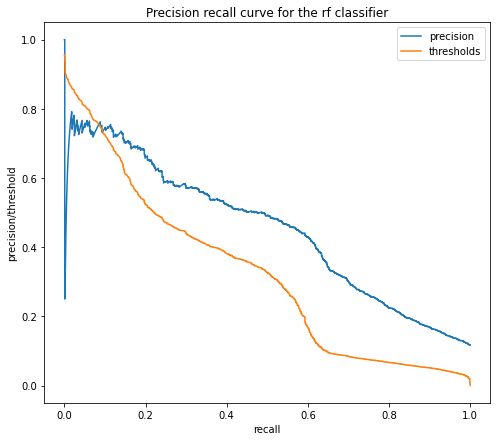

Model accuracy :  0.823
Model precision :  0.356
Model recall =  0.644
Confusion Matrix : 
 [[ 677  374]
 [1227 6750]]


In [2]:
from subscription_forecast.domain import model_evaluation
from subscription_forecast.domain.model_evaluation import ModelEvaluator
from subscription_forecast.domain import feature_engineering
from subscription_forecast.infrastructure import preprocessing
from subscription_forecast.application import final_model_prediction

import yaml

In [3]:
config_path ="../config/config.yml"

In [4]:
with open(config_path, 'r') as file_in:
    CONFIG = yaml.safe_load(file_in)

In [7]:
TARGET = CONFIG['filters']['TARGET']
features_to_drop = CONFIG['filters']['features_to_drop']

## Choix de critères d'évaluation

Premièrement il nous fallait décider de critères pour évaluer la performance de notre modèle. Il nous a paru important de faire attention aux nombre de <b> vrai positifs </b> et de <b> faux négatifs </b>, en d'autre termes: combien d'acheteurs potentiels ont été identifiés par le modèle, et combien on été raté. Il semble plus important de ne pas rater d'acheteurs, plutôt que d'appeler trop de clients.


Pour celà, nous avons décider de s'intéresser à la <b> precision </b> et au <b> recall </b>. En particulier, nous nous interesseront à la courbe precision/recall. Pour comparer la performance de nos modèle, nous comparerons les valeurs de l'aire sous la courbe precision/rerall (<b> Precision/Recall AUC </b>).

## Choix d'un algorythme d'apprentissage

Nous voulions avant tout avoir un modèle de classification facilement explicable. Nous sommes donc parti sur 2 types d'algorithmes:     <br>
- La Régression Logistique
- Le Random Forest

A chaque étape du feature engineering, nous avons comparé la régression logistique et le random forest. Pour chaque configuration, les performances du random forest étaient bien meilleures. 

### Regression logistique après feature engineering:

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#### preprocessing des datas:

In [12]:
client_full = preprocessing.features_from(CONFIG['data']['data_path'],
                                          CONFIG['data']['client_file_name'],
                                          CONFIG['data']['socio_eco_file_name'],
                                          features_to_drop)

#### préparation du train set et du test pour évaluer le modèle:

In [7]:
y = client_full[TARGET]
y = y.replace({'Yes': 1, 'No': 0})
x = client_full.drop(columns=TARGET)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

#### fit du pipeline de régression logistique

In [27]:
MODEL_NAME = 'lr'

final_pipeline = Pipeline(steps=[
        ('transformer', feature_engineering.transformer),
        (MODEL_NAME, LogisticRegression(C=1))])

final_pipeline.fit(x_train, y_train);

#### Evaluation des performances du modèle obtenu:

Model train accuracy :  0.893
Model accuracy :  0.889
Model precision :  0.574
Model recall =  0.185
Confusion Matrix : 
 [[ 194  857]
 [ 144 7833]]
AUC precision recall curve is :  0.407


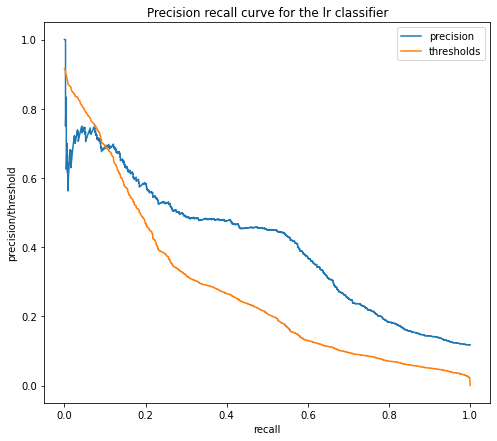

In [28]:
evaluator = ModelEvaluator(MODEL_NAME, final_pipeline)

evaluator.print_metrics(x_test, y_test, x_train, y_train)
evaluator.plot_precision_recall(x_test, y_test, x_train, y_train)

Nous obtenons ici 2 choses importantes: <br>
- Les métriques de performance du modèle avec le seuil (threshold) naturel de 0.5
- La courbe de precision recall liée à la variation du seuil
<br>

Nous reparleront plus tard de l'importance de toutes ces métriques, étudions maintenant le Random Forest.

### Résultats avec le Random Forest

In [17]:
MODEL_NAME = 'rf'

final_pipeline = Pipeline(steps=[
        ('transformer', feature_engineering.transformer),
        (MODEL_NAME, RandomForestClassifier(random_state=12, n_estimators=100, max_depth=8))])

final_pipeline.fit(x_train, y_train);

#### Evaluation des performances du Random Forest

Model train accuracy :  0.902
Model accuracy :  0.896
Model precision :  0.702
Model recall =  0.196
Confusion Matrix : 
 [[ 203  831]
 [  86 7716]]
AUC precision recall curve is :  0.474


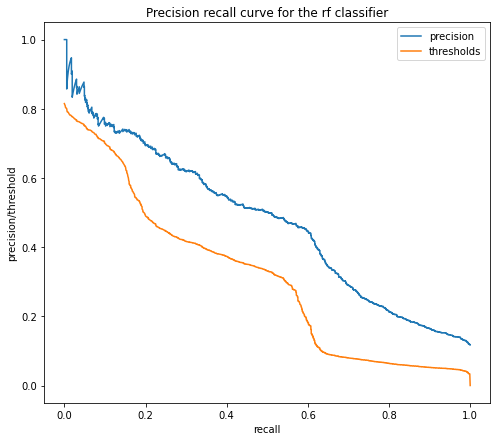

In [18]:
evaluator = ModelEvaluator(MODEL_NAME, final_pipeline)

evaluator.print_metrics(x_test, y_test, x_train, y_train)
evaluator.plot_precision_recall(x_test, y_test, x_train, y_train)

Avec des hyper paramètres non optimisés, nous observons que le Random forest a une meilleure air sous la courbe (AUC) que la régression logistique, ce qui nous interesse particulièrement. De plus, lorsqu'on diminue le seuil de classification, la courbe de précision/recall "tombe" moins vite pour le Random Forest. <br> 

Celà signifie que d'une part, l'algorithme est plus performant, et que d'autre part, nous allons pouvoir faire varier le seuil de prédiction afin d'obtenir une balance precision/recall plus satisfaisante. <br>

L'algorithme préférable semble être le Random Forest

## Choix des features

La phase d'EDA nous a permis de pré sélectionner les features à ne pas garder pour l'optimisation. <br>
De plus Job_type nous n'utiliserons pas job_type. Cette variable semble relativement corréler à la cible, mais malgrès nos efforts nous n'avons pas réussi à augmenter les performances du modèle en l'ajoutant.

In [42]:
print("features non utilisées:")
CONFIG['filters']['features_to_drop']

features non utilisées:


['contact',
 'duration_contact',
 'nb_contact_last_campaign',
 'has_default',
 'job_type']

De nombreuses combinaisons de features et de feature engineering ont été testé sur base de l'augmentation des performance des algorithmes. De plus, l'affichage de l'importance des feature (pour le RF) ou des coefficients (pour le RL) nous a permit d'évaluer leur impact.

#### exemple pour le random forest:

In [43]:
evaluator.get_feature_importance()

Feature importance: 
 [0.189 0.057 0.107 0.044 0.019 0.004 0.006 0.002 0.005 0.008 0.002 0.162
 0.074 0.182 0.036 0.003 0.036 0.064]


Dans l'ordre, les features retenues sont:
- Result_last_campaign: 1 si succes, 0 pour toues les autre cas
- Age: Nan imputé à la mediane, Robust scaler
- Date: les mois on été extraits de la date puis target encodé
- Balance et Nb_contact : Robust Scaler
- Education et Status: One hot encoder
- Socio_eco features: Robust scaler
- housing_loan and perso_loan : encodé, 2 si les 2 loans sont true, 1 pour 1 loan, 0 sinon
- day_last_contact: transformation 1/x


L'utilisation de ces features nous a permis d'améliorer la performance pour les 2 algorithmes.

## valeurs manquantes:


Il est possible d'améliorer la prédiction en gardant que les lignes avec moins de 3 valeurs manquantes après le préprocessing:

In [13]:
client_full, rows_removed = preprocessing.drop_nan(client_full)

Before preprocessing the dataset contains date                             0
age                              0
status                        1128
education                     1853
balance                          0
has_housing_loan                 0
has_perso_loan                1354
nb_contact                       0
nb_day_last_contact              0
result_last_campaign         36939
subscription                     0
employment_variation_rate        0
idx_consumer_price               0
idx_consumer_confidence          0
dtype: int64 missing values
After preprocessing the dataset contains date                             0
age                              0
status                         182
education                     1787
balance                          0
has_housing_loan                 0
has_perso_loan                 397
nb_contact                       0
nb_day_last_contact              0
result_last_campaign         35989
subscription                     0
employment_var

In [19]:
rows_removed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 957 entries, 1 to 45091
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       957 non-null    object 
 1   age                        957 non-null    int64  
 2   status                     11 non-null     object 
 3   education                  891 non-null    object 
 4   balance                    957 non-null    int64  
 5   has_housing_loan           957 non-null    object 
 6   has_perso_loan             0 non-null      object 
 7   nb_contact                 957 non-null    int64  
 8   nb_day_last_contact        957 non-null    int64  
 9   result_last_campaign       7 non-null      object 
 10  subscription               957 non-null    object 
 11  employment_variation_rate  957 non-null    float64
 12  idx_consumer_price         957 non-null    float64
 13  idx_consumer_confidence    957 non-null    float